In [41]:
%matplotlib inline
import pandas as pd
from sklearn.preprocessing import StandardScaler, MinMaxScaler
import numpy as np
from sklearn.ensemble import RandomForestRegressor
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA 
import torch
import torch.nn as nn
from torch.autograd import Variable
from torch.utils.data import  DataLoader
from tqdm.notebook import tqdm
from sklearn.metrics import mean_squared_error as mse, r2_score as r2


In [11]:
X = pd.read_csv("./data/processed/gw_stage2.CSV",
                    parse_dates=['Datetime'],
                    index_col=['Datetime'])
print('Initial Input Size: ',X.shape)
wak = pd.read_csv("./data/processed/DailyWakulla.CSV",
                    parse_dates=['datetime'],
                    index_col=['datetime'])
key_value = np.loadtxt("./data/processed/NameKey2.CSV", dtype= "str", delimiter=",", skiprows=1)
stationNames = { k:v for k,v in key_value }
#print(stationNames)
tooClose=['8','9','10','12','13','14','25', '44', '61', '72']
for i in tooClose:
    print(stationNames[i])

#Drop values exctremely close to the Sprin head
X.drop(X.columns[[8,9,10,12,13, 14, 25,44,61,72]], axis=1, inplace=True)
print("Excluded Input Shape: ", X.shape)
X.rename(columns = stationNames, inplace = True)
train_names=X.columns

#print (X)
GW=X.iloc[:,:23]
SW=X.iloc[:,23:]
#print(SW)
dates=X.index
print(dates[770])

Initial Input Size:  (1101, 74)
NWFWMD-NITRATE 1
NWFWMD-NITRATE 2/S790
NWFWMD-NITRATE 4/S782
NWFWMD-NITRATE 6/S797
WAKULLA CORRECTIONAL INSTITUTE 1/S779
WAKULLA CONDUIT WELL@WEST OF HWY 61
NWFWMD GW-12F (RIVERSPRINGS MS)/S820
St. Marks River @ San Marcos de Apalachee S.P.
WAKULLA RIVER AT BOAT TRAM
INDIAN SPRING RUN AT SR61
Excluded Input Shape:  (1101, 64)
2019-03-08 00:00:00


In [83]:
y=wak['Temp_C'].to_frame()


In [84]:
mm=MinMaxScaler()
ss=StandardScaler()
X_ss=ss.fit_transform(X)
y_mm=mm.fit_transform(y)
print()
#Splitting to a 70 Train:30 Test
print('Combined Shapes')
X_train=X_ss[:770,:]
X_test=X_ss[770:,:]
y_train=y_mm[:770,:]
y_test=y_mm[770:,:]

print(X_train.shape)
print(y_train.shape)
print(X_test.shape)
print(y_test.shape)


Combined Shapes
(770, 64)
(770, 1)
(331, 64)
(331, 1)


In [85]:
X_train_tensors = Variable(torch.Tensor(X_train))
X_test_tensors = Variable(torch.Tensor(X_test))
#Spring Tensors
y_train_tensors = Variable(torch.Tensor(y_train))
y_test_tensors = Variable(torch.Tensor(y_test))

X_train_tensors_final = torch.reshape(X_train_tensors,   (X_train_tensors.shape[0], 1, X_train_tensors.shape[1]))
X_test_tensors_final = torch.reshape(X_test_tensors,  (X_test_tensors.shape[0], 1, X_test_tensors.shape[1]))

print("Both Training Shape. Input: ", X_train_tensors_final.shape, " Target: ",y_train_tensors.shape)
print("Both Testing Shape. Input", X_test_tensors_final.shape, " Target: ",y_test_tensors.shape) 

Both Training Shape. Input:  torch.Size([770, 1, 64])  Target:  torch.Size([770, 1])
Both Testing Shape. Input torch.Size([331, 1, 64])  Target:  torch.Size([331, 1])


In [86]:
#Hyper Parameters #BOTH
num_epochs = 500 #1000 epochs
learning_rate = 0.001 #0.001 lr
BATCH_SIZE=14
input_size = 64 #number of features
hidden_size = 64 #number of features in hidden state
num_layers = 1 #number of stacked lstm layers

num_classes = 1 #number of output classes 

In [87]:
lstm1 = LSTM1(num_classes, input_size, hidden_size, num_layers, X_train_tensors_final.shape[1]) #our lstm class 
criterion = torch.nn.MSELoss()    # mean-squared error for regression
optimizer = torch.optim.Adam(lstm1.parameters(), lr=learning_rate) 

print(lstm1)

LSTM1(
  (lstm): LSTM(64, 64, batch_first=True)
  (dropout): Dropout(p=0.5, inplace=False)
  (fc_1): Linear(in_features=64, out_features=64, bias=True)
  (fc): Linear(in_features=64, out_features=1, bias=True)
  (relu): ReLU()
)


In [88]:
train_loss_list = []
test_loss_list = []

for epoch in range(num_epochs):
    
    outputs = lstm1.forward(X_train_tensors_final) #forward pass
    optimizer.zero_grad() #caluclate the gradient, manually setting to 0
 
  # obtain the loss function
    loss_train = criterion(outputs, y_train_tensors)
    
    #Save train loss to list
    loss_train_l=loss_train.detach().numpy()
    train_loss_list.append(loss_train_l)
    
    # Get and Save validation losses
    test_out=lstm1.forward(X_test_tensors_final)
    test_loss = criterion(test_out, y_test_tensors)
    test_loss=test_loss.detach().numpy()
    test_loss_list.append(test_loss)
    
    loss_train.backward() #calculates the loss of the loss function
    optimizer.step() #improve from loss, i.e backprop
    if epoch % 100 == 0:
        print("Epoch: %d, loss: %1.5f" % (epoch, loss_train.item())) 

Epoch: 0, loss: 0.40662
Epoch: 100, loss: 0.02164
Epoch: 200, loss: 0.01458
Epoch: 300, loss: 0.01388
Epoch: 400, loss: 0.01283


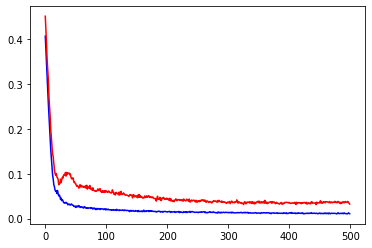

444


In [89]:
plt.plot(train_loss_list, 'b', test_loss_list, 'r')
plt.show()

min_test_loss=min(test_loss_list)
index=test_loss_list.index(min_test_loss)

print(index)

In [90]:
new_num_epochs=100

lstm2 = LSTM1(num_classes, input_size, hidden_size, num_layers, X_train_tensors_final.shape[1]) #our lstm class 
criterion = torch.nn.MSELoss()    # mean-squared error for regression
optimizer = torch.optim.Adam(lstm2.parameters(), lr=learning_rate) 

train_loss_list = []
test_loss_list = []

for epoch in range(new_num_epochs):
    
    outputs = lstm2.forward(X_train_tensors_final) #forward pass
    optimizer.zero_grad() #caluclate the gradient, manually setting to 0
 
    loss_train = criterion(outputs, y_train_tensors)
    
    #Save train loss to list
    loss_train_l=loss_train.detach().numpy()
    train_loss_list.append(loss_train_l)
    
    # Get and Save validation losses
    test_out=lstm1.forward(X_test_tensors_final)
    test_loss = criterion(test_out, y_test_tensors)
    test_loss=test_loss.detach().numpy()
    test_loss_list.append(test_loss)
    
    
    loss_train.backward() #calculates the loss of the loss function
    optimizer.step() #improve from loss, i.e backprop
    if epoch % 10 == 0:
        print("Epoch: %d, loss: %1.5f" % (epoch, loss_train.item())) 

Epoch: 0, loss: 0.56351
Epoch: 10, loss: 0.23393
Epoch: 20, loss: 0.07926
Epoch: 30, loss: 0.05094
Epoch: 40, loss: 0.03873
Epoch: 50, loss: 0.03231
Epoch: 60, loss: 0.02841
Epoch: 70, loss: 0.02828
Epoch: 80, loss: 0.02654
Epoch: 90, loss: 0.02531


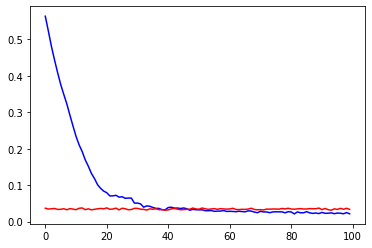

93


In [91]:
plt.plot(train_loss_list, 'b', test_loss_list, 'r')
plt.show()

min_test_loss=min(test_loss_list)
index=test_loss_list.index(min_test_loss)

print(index)

In [92]:
df_X_ss = Variable(torch.Tensor(X_ss)) #converting to Tensors
df_y_mm = Variable(torch.Tensor(y_mm))
#reshaping the dataset
df_X_ss = torch.reshape(df_X_ss, (df_X_ss.shape[0], 1, df_X_ss.shape[1]))

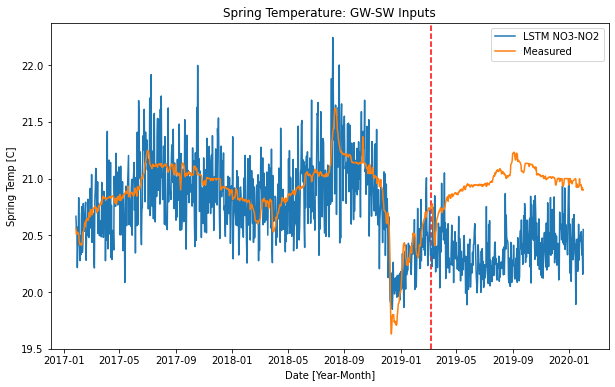

In [93]:
train_predict = lstm2(df_X_ss)#forward pass
data_predict = train_predict.data.numpy() #numpy conversion
dataY_plot = df_y_mm.data.numpy()

data_predict = mm.inverse_transform(data_predict) #reverse transformation
dataY_plot = mm.inverse_transform(dataY_plot)
plt.figure(figsize=(10,6)) #plotting
plt.axvline(x=dates[770], c='r', linestyle='--') #size of the training set

plt.plot(dates, data_predict, label='LSTM NO3-NO2') #predicted plot

plt.plot(dates, dataY_plot, label='Measured') #actual plot
plt.title('Spring Temperature: GW-SW Inputs')
plt.ylabel("Spring Temp [C]")
plt.xlabel("Date [Year-Month]")
plt.legend()
plt.savefig('./plots/ChemLSTM/LSTM_Temp.SVG')

plt.show()
plt.close()



In [39]:
def nse(predictions, targets):
    return (1-(np.sum((predictions-targets)**2)/np.sum((targets-np.mean(targets))**2)))

In [59]:
#####Performance Method of Test set
#reshaping the dataset
df_X_ss = Variable(torch.Tensor(X_test)) #converting to Tensors
df_y_mm = Variable(torch.Tensor(y_test))
#reshaping the dataset
df_X_ss = torch.reshape(df_X_ss, (df_X_ss.shape[0], 1, df_X_ss.shape[1]))
train_predict = lstm2(X_test_tensors_final)#forward pass
predict_scaled = train_predict.data.numpy() #numpy conversion

predictTest = mm.inverse_transform(predict_scaled)
actualTest = mm.inverse_transform(y_test)

test_rmse=mse(actualTest, predictTest)**0.5
#mae_score= mae(actualTest, predictTest)
test_r_sq=r2(actualTest, predictTest)

full_rmse=mse(dataY_plot, data_predict)**0.5
full_r_sq=r2(dataY_plot, data_predict)
full_nse=nse(data_predict,dataY_plot)
print("Test RMSE:" , test_rmse, "\nTest R2: ", test_r_sq, "\nFull RMSE:" , full_rmse, "\nfull R2: ", full_r_sq,
     "\nNSE: ", full_nse)

Test RMSE: 0.23353267946013137 
Test R2:  -1.9351350080438463 
Full RMSE: 0.19684652622128596 
full R2:  0.38572823916875654 
NSE:  0.3857281804084778
